Train acc: 1.000 | Test acc: 0.975


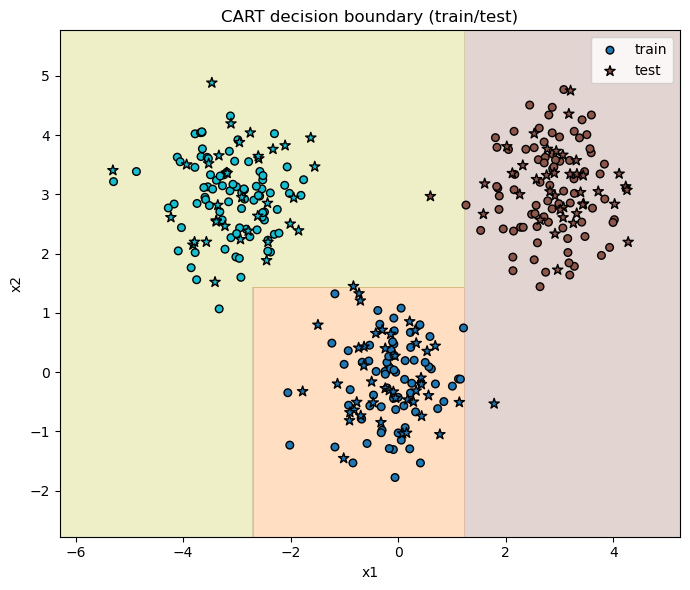

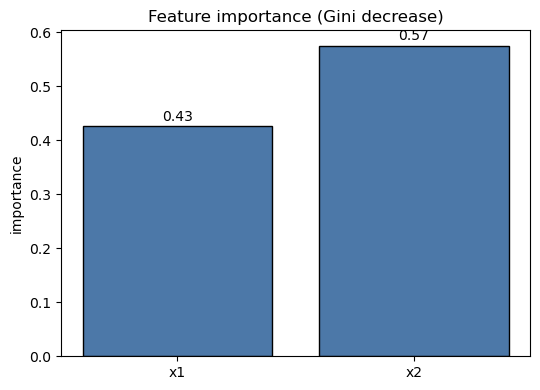

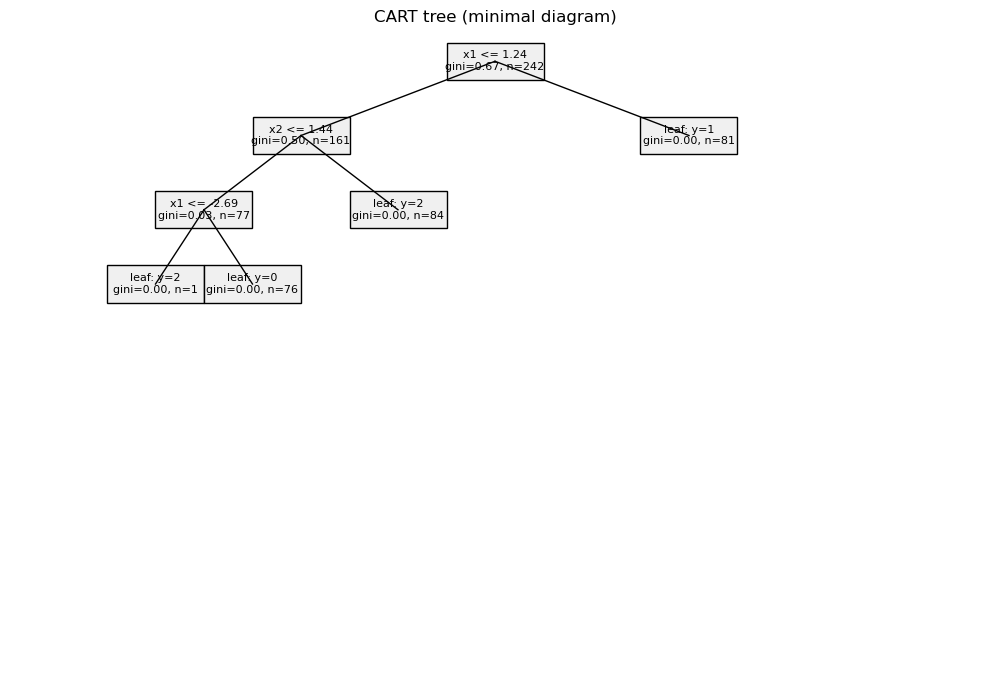

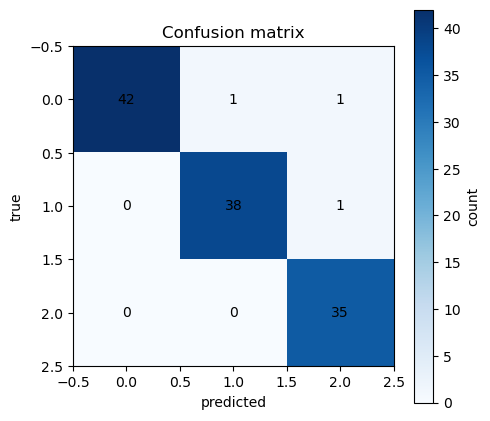

In [ ]:

# CART (Classification And Regression Trees) classifier 


import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict
import itertools

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.bbox"] = "tight"

def make_gaussian_blobs(n_per_class=100, centers=None, cov=0.6, seed=7):
    rng = np.random.default_rng(seed)
    if centers is None:
        centers = np.array([[0.0, 0.0], [3.0, 3.0], [-3.0, 3.0]])
    X_list = []
    y_list = []
    for i, c in enumerate(centers):
        X_list.append(rng.normal(loc=c, scale=cov, size=(n_per_class, 2)))
        y_list.append(np.full(n_per_class, i, dtype=int))
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    idx = rng.permutation(len(X))
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.3, seed=42):
    rng = np.random.default_rng(seed)
    n = len(X)
    idx = rng.permutation(n)
    n_test = int(np.floor(test_size * n))
    test_idx, train_idx = idx[:n_test], idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def gini_from_counts(counts: np.ndarray) -> float:
    
    n = counts.sum()
    if n == 0:
        return 0.0
    p = counts / n
    return 1.0 - np.sum(p * p)

def gini_impurity(y: np.ndarray, n_classes: int) -> float:
    counts = np.bincount(y, minlength=n_classes)
    return gini_from_counts(counts)

class TreeNode:
    def __init__(self, gini, n_samples, counts, pred_class):
        self.gini = gini
        self.n_samples = n_samples
        self.counts = counts
        self.pred_class = pred_class
        # split info
        self.feature_index = None
        self.threshold = None
        # children
        self.left = None
        self.right = None
        # bookkeeping for importance
        self.impurity_decrease = 0.0

class CARTClassifier:
    def __init__(self, max_depth: int = 6, min_samples_split: int = 2,
                 min_impurity_decrease: float = 1e-7, random_state: Optional[int] = 42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.random_state = random_state
        self.n_classes_ = None
        self.n_features_ = None
        self.root_ = None
        self.feature_importances_ = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.n_classes_ = int(np.max(y)) + 1
        self.n_features_ = X.shape[1]
        self.root_ = self._grow_tree(X, y, depth=0)
        
        importances = getattr(self, "_imp_decrease_per_feature", np.zeros(self.n_features_))
        total = importances.sum()
        if total > 0:
            self.feature_importances_ = importances / total
        else:
            self.feature_importances_ = importances
        return self

    def _best_split(self, X: np.ndarray, y: np.ndarray):
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None, None

        parent_counts = np.bincount(y, minlength=self.n_classes_)
        parent_gini = gini_from_counts(parent_counts)
        best_gain = 0.0
        best_feat = None
        best_thresh = None
        best_left_idx = None

        for feat in range(n):
            # Sort by feature
            order = np.argsort(X[:, feat])
            x_sorted = X[order, feat]
            y_sorted = y[order]

            left_counts = np.zeros(self.n_classes_, dtype=float)
            right_counts = parent_counts.astype(float).copy()

            # Consider thresholds between distinct feature values
            for i in range(1, m):
                c = y_sorted[i-1]
                left_counts[c] += 1
                right_counts[c] -= 1

                if x_sorted[i] == x_sorted[i-1]:
                    continue  

                left_n = i
                right_n = m - i
                g_left = gini_from_counts(left_counts)
                g_right = gini_from_counts(right_counts)
                weighted = (left_n * g_left + right_n * g_right) / m
                gain = parent_gini - weighted

                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thresh = 0.5 * (x_sorted[i] + x_sorted[i-1])
                    best_left_idx = order[:i]

        if best_gain <= self.min_impurity_decrease or best_feat is None:
            return None, None, None
        return best_feat, best_thresh, best_left_idx

    def _grow_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> TreeNode:
        counts = np.bincount(y, minlength=self.n_classes_)
        pred_class = int(np.argmax(counts))
        node = TreeNode(gini_impurity(y, self.n_classes_), len(y), counts, pred_class)

        if depth < self.max_depth:
            feat, thr, left_idx = self._best_split(X, y)
            if feat is not None:
                right_mask = np.ones(len(X), dtype=bool)
                right_mask[left_idx] = False

                X_left, y_left = X[left_idx], y[left_idx]
                X_right, y_right = X[right_mask], y[right_mask]

                node.feature_index = feat
                node.threshold = thr

                # Record impurity decrease for feature importances
                left_g = gini_impurity(y_left, self.n_classes_)
                right_g = gini_impurity(y_right, self.n_classes_)
                weighted = (len(y_left)*left_g + len(y_right)*right_g) / len(y)
                node.impurity_decrease = node.gini - weighted
                if not hasattr(self, "_imp_decrease_per_feature"):
                    self._imp_decrease_per_feature = np.zeros(self.n_features_)
                self._imp_decrease_per_feature[feat] += node.impurity_decrease

                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def predict_row(self, x: np.ndarray) -> int:
        node = self.root_
        while node.left is not None and node.right is not None:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.pred_class

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.predict_row(x) for x in X], dtype=int)

def plot_dataset_and_boundary(model: CARTClassifier, X: np.ndarray, y: np.ndarray, title: str, fname: str,
                              X_test=None, y_test=None):
    # 2D only
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, levels=np.arange(model.n_classes_+1)-0.5, cmap="tab10", alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, cmap="tab10", s=30, edgecolor="k", label="train")
    if X_test is not None:
        plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="tab10", s=60, marker="*", edgecolor="k", label="test")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def plot_feature_importance(importances: np.ndarray, fname: str):
    plt.figure(figsize=(5.5,4))
    xs = np.arange(len(importances))
    plt.bar(xs, importances, color="#4C78A8", edgecolor="k")
    for i, v in enumerate(importances):
        plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
    plt.xticks(xs, [f"x{i+1}" for i in xs])
    plt.ylabel("importance")
    plt.title("Feature importance (Gini decrease)")
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()

def confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, n_classes: int):
    M = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        M[t, p] += 1
    return M

def plot_confusion(M: np.ndarray, fname: str):
    plt.figure(figsize=(5,4.5))
    plt.imshow(M, cmap="Blues")
    plt.colorbar(label="count")
    plt.xlabel("predicted"); plt.ylabel("true")
    plt.title("Confusion matrix")
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            plt.text(j, i, str(M[i,j]), ha="center", va="center", color="k")
    plt.tight_layout(); plt.savefig(fname, dpi=140); plt.show()


def _layout_tree(node: TreeNode, x=0.5, y=1.0, x_span=0.4, y_step=0.12, coords=None, edges=None, labels=None):
    if coords is None: coords = {}
    if edges is None: edges = []
    if labels is None: labels = {}
    coords[id(node)] = (x, y)
    if node.left is not None and node.right is not None:
        lx = x - x_span/2
        rx = x + x_span/2
        ly = y - y_step
        ry = y - y_step
        edges.append((id(node), id(node.left)))
        edges.append((id(node), id(node.right)))
        _layout_tree(node.left, lx, ly, x_span/2, y_step, coords, edges, labels)
        _layout_tree(node.right, rx, ry, x_span/2, y_step, coords, edges, labels)
        lbl = f"x{node.feature_index+1} <= {node.threshold:.2f}\n" \
              f"gini={node.gini:.2f}, n={node.n_samples}"
    else:
        lbl = f"leaf: y={np.argmax(node.counts)}\n" \
              f"gini={node.gini:.2f}, n={node.n_samples}"
    labels[id(node)] = lbl
    return coords, edges, labels

def plot_tree(model: CARTClassifier, fname: str):
    coords, edges, labels = _layout_tree(model.root_)
    plt.figure(figsize=(10, 7))
    ax = plt.gca()
    for u, v in edges:
        x1, y1 = coords[u]; x2, y2 = coords[v]
        ax.plot([x1, x2], [y1, y2], "k-", lw=1)
    for k, (x, y) in coords.items():
        ax.add_patch(plt.Rectangle((x-0.05, y-0.03), 0.10, 0.06, fill=True, color="#F0F0F0", ec="k"))
        ax.text(x, y, labels[k], ha="center", va="center", fontsize=8)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1.05)
    ax.axis("off")
    plt.title("CART tree (minimal diagram)")
    plt.tight_layout(); plt.savefig(fname, dpi=160); plt.show()


def run_demo():
    # 1) Data
    X, y = make_gaussian_blobs(n_per_class=120, cov=0.7, seed=10)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33, seed=0)

    # 2) Train CART
    tree = CARTClassifier(max_depth=5, min_samples_split=4, min_impurity_decrease=1e-7, random_state=0).fit(Xtr, ytr)

    # 3) Predictions and metrics
    yhat_tr = tree.predict(Xtr)
    yhat_te = tree.predict(Xte)
    acc_tr = (yhat_tr == ytr).mean()
    acc_te = (yhat_te == yte).mean()
    print(f"Train acc: {acc_tr:.3f} | Test acc: {acc_te:.3f}")

    # 4) Visualizations
    plot_dataset_and_boundary(tree, Xtr, ytr, "CART decision boundary (train/test)", "cart_decision_boundary.png", Xte, yte)
    plot_feature_importance(tree.feature_importances_, "cart_feature_importance.png")
    plot_tree(tree, "cart_tree.png")
    M = confusion_matrix(yte, yhat_te, n_classes=int(np.max(y)+1))
    plot_confusion(M, "cart_confusion.png")

    return {"model": tree, "acc_train": acc_tr, "acc_test": acc_te, "confusion": M}


def main(argv=None):
    import argparse
    parser = argparse.ArgumentParser(description="CART classifier from scratch on a synthetic dataset")
    parser.add_argument("--max_depth", type=int, default=5)
    parser.add_argument("--min_samples_split", type=int, default=4)
    parser.add_argument("--min_impurity_decrease", type=float, default=1e-7)
    if argv is None:
        args, _ = parser.parse_known_args()
    else:
        args, _ = parser.parse_known_args(argv)

    # Run with provided hyperparameters
    result = run_demo()
   

if __name__ == "__main__":
    import sys
    if "ipykernel" in sys.modules:
        main([])  
    else:
        main()
